In [1]:
import pandas as pd
import json
from utils import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,  r2_score
from energy_ml.models.other_models import non_DNN_regressor
from energy_ml.models.KFold_validation import KFold_Validation_non_DNN
from energy_ml.models.neural_network import *
from energy_ml.Config import *
from energy_ml.models.test_all_regressors import test_all_regressors
from energy_ml.models.confidence_rate import confidence_rate

# 1. Read data

In [3]:
X_df = pd.read_csv('../input/REHO/REHO_train_X.csv')
y_df = pd.read_csv('../input/REHO/REHO_train_y.csv')

with open("../input/REHO/feature_slices.json", "r") as f:
    feature_slices = json.load(f)

feature_slices = {k: tuple(v) for k, v in feature_slices.items()} # This defines the blocks of features in the input matrix X


## Data rescaling

In [4]:
# Split X into blocks
X_parts = {}
for name, (start, end) in feature_slices.items():
    X_parts[name] = X_df.iloc[:, start:end].to_numpy()
y_matrix = y_df.to_numpy()

# Define parameter set
Parameter_Dict = {}

# Add feature slices into parameter set
Parameter_Dict['index_ranges'] = feature_slices

# Add configuration labels
Parameter_Dict['Configuration_Labels'] = y_df.columns.tolist()



# Rescaling X_df. Temperature, irradiation and typical days are scale by the whole block
Parameter_Dict[('Building', 'max')], Parameter_Dict[('Building', 'min')], Building_Matrix = scale_matrix_0_1(X_parts['Building'])
Parameter_Dict[('Temperature', 'max')], Parameter_Dict[('Temperature', 'min')], Temperature_Matrix = scale_matrix_0_1(X_parts['Temperature'], isByRow=False)
Parameter_Dict[('Irradiation', 'max')], Parameter_Dict[('Irradiation', 'min')], Irradiation_Matrix = scale_matrix_0_1(X_parts['Irradiation'], isByRow=False)
Parameter_Dict[('TypicalDay', 'max')], Parameter_Dict[('TypicalDay', 'min')], TypicalDay_Matrix = scale_matrix_0_1(X_parts['TypicalDay'], isByRow=False)
Parameter_Dict[('MarketData', 'max')], Parameter_Dict[('MarketData', 'min')], MarketData_Matrix = scale_matrix_0_1(X_parts['MarketData'])

# Concatenate to get X
X = np.concatenate([Building_Matrix, Temperature_Matrix, Irradiation_Matrix, TypicalDay_Matrix, MarketData_Matrix], axis=1)

# Rescale y_df. The lower bound is set to 0 to avoid nan value when choosing sqrt or log scaler
Rescale_Type = 'normal'
augmented_segment = 0.3

Parameter_Dict['Configuration_Rescale_Type'] = Rescale_Type
Parameter_Dict['augmented_segment'] = augmented_segment

Parameter_Dict[('Configuration', 'max')], Parameter_Dict[('Configuration', 'min')], y= scale_matrix_0_1(y_df, Rescale_Type= Rescale_Type, lower_bound= 0, augmented_segment = augmented_segment)


## Split training and validation dataset

In [21]:
# Shuffle dataset order (optional)
X, y = shuffle_dataset(X, y)

TrainNumber = int(X.shape[0] * 0.9)
X_train = X[:TrainNumber]
X_valid = X[TrainNumber:]

y_train = y[:TrainNumber]
y_valid = y[TrainNumber:]


## Data augmentation (optional)

In [22]:
augmented_number = 3*X_train.shape[0]
X_train, y_train = augment_typical_days(X_train, y_train, Parameter_Dict, augmented_number)

# 2. Model training

In [23]:
#validation_results,  regressor_list = test_all_regressors(X_train, y_train, X_valid, y_valid)
validation_results,  regressor_list = DNN_regressor(X_train, y_train, X_valid, y_valid, regressor_list = [12],verbose=1, batch_size= 1280)
validation_results_non_DNN,  regressor_list_non_DNN = non_DNN_regressor(X_train, y_train, X_valid, y_valid, regressor_list = ['RandomForestRegressor'])

Current model name:  DeepNeuralNetwork_model_12
Current model structure:  [1024, 256, 128, 32]


/Users/bliu/Desktop/Projects/GithubProject/SmartEnergy/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2625 - mae: 0.2625 - mse: 0.1303 - val_loss: 0.1202 - val_mae: 0.1202 - val_mse: 0.0345
Epoch 2/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1188 - mae: 0.1188 - mse: 0.0380 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0259
Epoch 3/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1069 - mae: 0.1069 - mse: 0.0279 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0259
Epoch 4/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1061 - mae: 0.1061 - mse: 0.0272 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0259
Epoch 5/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1051 - mae: 0.1051 - mse: 0.0265 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0259
Epoch 6/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1052 - mae: 0.1052 - mse: 0.0265 - val_loss: 0.1046 - val_mae: 0.1046 - val_mse: 0.0259
Epoch 7/5000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1051 - mae: 0.1051 - mse: 0.026

In [7]:
# Summarize learning results in a data frame
df_results = pd.DataFrame.from_dict(validation_results, orient='index')
df_results = df_results.reset_index().rename(columns={'index': 'ModelName'})
df_results = df_results.sort_values(by='valid_MAE', ascending=True)

In [8]:
df_results

,ModelName,valid_MAE,valid_MSE,train_MAE,train_MSE,training_time
0,DeepNeuralNetwork_model_12,0.015889,0.003289,0.016024,0.003395,122.592734


# 3. Prediction on validation data

## Confidence score of tree based models

In [24]:
# Building number to predict
building_number = 102

#prediction

model = regressor_list_non_DNN['RandomForestRegressor']

y_pred = model.predict(X_valid)


#rescale
y_pred_rescaled = inverse_scale_matrix_0_1(y_pred, Parameter_Dict)
y_test_rescaled = inverse_scale_matrix_0_1(y_valid, Parameter_Dict)

df = pd.DataFrame({
    "Technology": Parameter_Dict['Configuration_Labels'],
    "Predicted": y_pred_rescaled[building_number],
    "Actual": y_test_rescaled[building_number]
})

# Function to format values: round to two significant figures and set to 0 if below 1e-3
def format_value(x):
    return "0" if abs(x) < 1e-3 else f"{x:.3g}"

# Round to two significant figures
df["Predicted"] = df["Predicted"].apply(format_value)
df["Actual"] = df["Actual"].apply(format_value)

# Print the dataframe
print(df)

# Retrieve the prediction of all trees
confidence_rate_vector = confidence_rate(model, X_valid)
print("Confidence rate", confidence_rate_vector[building_number])

              Technology Predicted    Actual
0           WaterTankDHW         0         0
1        NG_Cogeneration         0         0
2    Air_Conditioner_Air         0         0
3                Battery         0         0
4           HeatPump_Air         0         0
5   ElectricalHeater_DHW         0         0
6            WaterTankSH       164       164
7    ElectricalHeater_SH         0         0
8                     PV  2.04e+03  2.04e+03
9              NG_Boiler         0         0
10          ThermalSolar      49.5      49.5
11   HeatPump_Geothermal  2.87e+03  2.87e+03
Confidence rate 0.9996119915175142


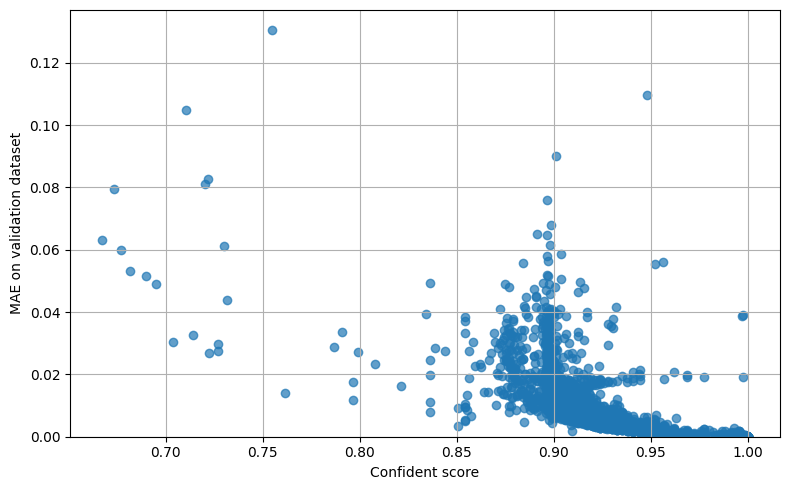

In [25]:
mae_list = calculate_mae_list(y_pred, y_valid)
plot_mae_vs_confidence(mae_list, confidence_rate_vector, title = None)

## Confidence score of DNN model

In [26]:
# Building number to predict
building_number = 10

#prediction

model = regressor_list['DeepNeuralNetwork_model_12']

y_pred = model.predict(X_valid)


#rescale
y_pred_rescaled = inverse_scale_matrix_0_1(y_pred, Parameter_Dict)
y_test_rescaled = inverse_scale_matrix_0_1(y_valid, Parameter_Dict)

df = pd.DataFrame({
    "Technology": Parameter_Dict['Configuration_Labels'],
    "Predicted": y_pred_rescaled[building_number],
    "Actual": y_test_rescaled[building_number]
})

# Function to format values: round to two significant figures and set to 0 if below 1e-3
def format_value(x):
    return "0" if abs(x) < 1e-3 else f"{x:.3g}"

# Round to two significant figures
df["Predicted"] = df["Predicted"].apply(format_value)
df["Actual"] = df["Actual"].apply(format_value)

# Print the dataframe
print(df)

# Retrieve the prediction of Monte-Carlo dropout
# Retrieve the prediction of all trees
confidence_rate_vector = confidence_rate(model, X_valid)
print("Confidence rate", confidence_rate_vector [building_number])

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
              Technology Predicted    Actual
0           WaterTankDHW         0         0
1        NG_Cogeneration    0.0232         0
2    Air_Conditioner_Air         0         0
3                Battery         0         0
4           HeatPump_Air      86.2      86.2
5   ElectricalHeater_DHW         0         0
6            WaterTankSH       165       165
7    ElectricalHeater_SH         0         0
8                     PV  2.04e+03  2.05e+03
9              NG_Boiler         0         0
10          ThermalSolar      50.6        52
11   HeatPump_Geothermal  2.87e+03  2.87e+03
Confidence rate 0.97545516


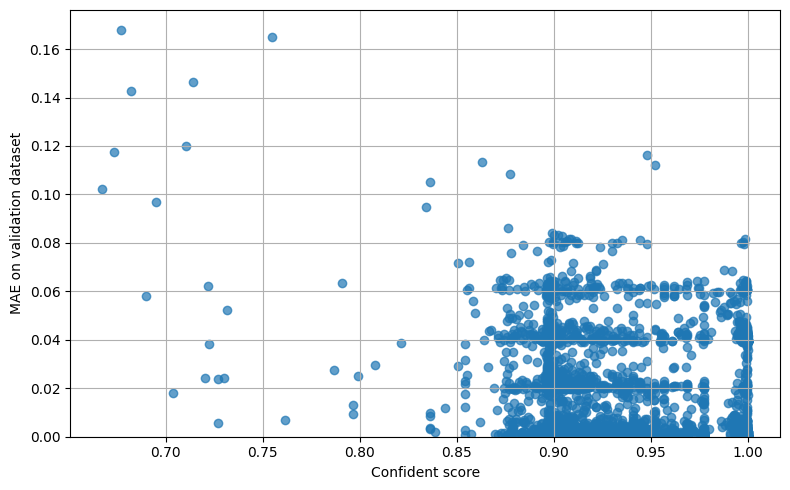

In [27]:
mae_list = calculate_mae_list(y_pred, y_valid)
plot_mae_vs_confidence(mae_list, confidence_rate_vector, title = None)

# 4. Prediction on test data

## Read test data

In [12]:
X_df_test = pd.read_csv('../input/REHO/REHO_test_X.csv')
y_df_test = pd.read_csv('../input/REHO/REHO_test_y.csv')

## Rescale test data

In [28]:
# Split X into blocks
X_parts_test = {}
for name, (start, end) in feature_slices.items():
    X_parts_test[name] = X_df_test.iloc[:, start:end].to_numpy()
y_matrix_test = y_df_test.to_numpy()


# Rescaling X_df. Temperature, irradiation and typical days are scale by the whole block
_, _, Building_Matrix_test = scale_matrix_0_1(
    X_parts_test['Building'],
    upper_bound=Parameter_Dict[('Building', 'max')],
    lower_bound=Parameter_Dict[('Building', 'min')]
)

_, _, Temperature_Matrix_test = scale_matrix_0_1(
    X_parts_test['Temperature'],
    isByRow=False,
    upper_bound=Parameter_Dict[('Temperature', 'max')],
    lower_bound=Parameter_Dict[('Temperature', 'min')]
)

_, _, Irradiation_Matrix_test = scale_matrix_0_1(
    X_parts_test['Irradiation'],
    isByRow=False,
    upper_bound=Parameter_Dict[('Irradiation', 'max')],
    lower_bound=Parameter_Dict[('Irradiation', 'min')]
)

_, _, TypicalDay_Matrix_test = scale_matrix_0_1(
    X_parts_test['TypicalDay'],
    isByRow=False,
    upper_bound=Parameter_Dict[('TypicalDay', 'max')],
    lower_bound=Parameter_Dict[('TypicalDay', 'min')]
)

_, _, MarketData_Matrix_test = scale_matrix_0_1(
    X_parts_test['MarketData'],
    upper_bound=Parameter_Dict[('MarketData', 'max')],
    lower_bound=Parameter_Dict[('MarketData', 'min')]
)

# Concatenate to get X
X_test = np.concatenate([Building_Matrix_test, Temperature_Matrix_test, Irradiation_Matrix_test, TypicalDay_Matrix_test, MarketData_Matrix_test], axis=1)

# Rescale y_df. The lower bound is set to 0 to avoid nan value when choosing sqrt or log scaler

_, _, y_test = scale_matrix_0_1(y_df, Rescale_Type= Rescale_Type, lower_bound= 0, augmented_segment = augmented_segment)

# Shuffle dataset order (optional)
X_test, y_test = shuffle_dataset(X_test, y_test)

## Confidence score of tree based models

In [29]:
# Building number to predict
building_number = 102

#prediction

model = regressor_list_non_DNN['RandomForestRegressor']

y_pred_test = model.predict(X_test)


#rescale
y_pred_rescaled_test = inverse_scale_matrix_0_1(y_pred_test, Parameter_Dict)
y_test_rescaled_test= inverse_scale_matrix_0_1(y_test, Parameter_Dict)

df = pd.DataFrame({
    "Technology": Parameter_Dict['Configuration_Labels'],
    "Predicted": y_pred_rescaled_test[building_number],
    "Actual": y_test_rescaled_test[building_number]
})

# Function to format values: round to two significant figures and set to 0 if below 1e-3
def format_value(x):
    return "0" if abs(x) < 1e-3 else f"{x:.3g}"

# Round to two significant figures
df["Predicted"] = df["Predicted"].apply(format_value)
df["Actual"] = df["Actual"].apply(format_value)

# Print the dataframe
print(df)

# Retrieve the prediction of all trees
confidence_rate_vector = confidence_rate(model, X_test)
print("Confidence rate", confidence_rate_vector[building_number])

              Technology Predicted    Actual
0           WaterTankDHW         0         0
1        NG_Cogeneration         0         0
2    Air_Conditioner_Air         0         0
3                Battery         0         0
4           HeatPump_Air         0         0
5   ElectricalHeater_DHW         0         0
6            WaterTankSH       164       164
7    ElectricalHeater_SH         0         0
8                     PV  2.03e+03  2.03e+03
9              NG_Boiler         0         0
10          ThermalSolar      48.9      48.9
11   HeatPump_Geothermal  2.87e+03  2.87e+03
Confidence rate 0.9999142993391791


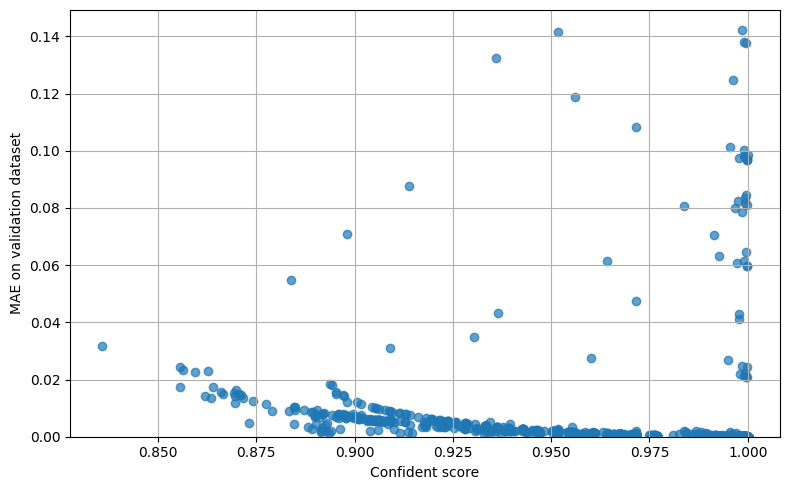

In [30]:
mae_list_test = calculate_mae_list(y_pred_test, y_test)
plot_mae_vs_confidence(mae_list_test, confidence_rate_vector, title = None)

## Confidence score of DNN models

In [31]:
# Building number to predict
building_number = 102

#prediction

model = regressor_list['DeepNeuralNetwork_model_12']

y_pred_test = model.predict(X_test)


#rescale
y_pred_rescaled_test = inverse_scale_matrix_0_1(y_pred_test, Parameter_Dict)
y_test_rescaled_test= inverse_scale_matrix_0_1(y_test, Parameter_Dict)

df = pd.DataFrame({
    "Technology": Parameter_Dict['Configuration_Labels'],
    "Predicted": y_pred_rescaled_test[building_number],
    "Actual": y_test_rescaled_test[building_number]
})

# Function to format values: round to two significant figures and set to 0 if below 1e-3
def format_value(x):
    return "0" if abs(x) < 1e-3 else f"{x:.3g}"

# Round to two significant figures
df["Predicted"] = df["Predicted"].apply(format_value)
df["Actual"] = df["Actual"].apply(format_value)

# Print the dataframe
print(df)

# Retrieve the prediction of all trees
confidence_rate_vector = confidence_rate(model, X_test)
print("Confidence rate", confidence_rate_vector[building_number])

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
              Technology Predicted    Actual
0           WaterTankDHW         0         0
1        NG_Cogeneration         0         0
2    Air_Conditioner_Air         0         0
3                Battery         0         0
4           HeatPump_Air         0         0
5   ElectricalHeater_DHW         0         0
6            WaterTankSH       164       164
7    ElectricalHeater_SH         0         0
8                     PV  2.04e+03  2.03e+03
9              NG_Boiler         0         0
10          ThermalSolar      48.7      48.9
11   HeatPump_Geothermal  2.86e+03  2.87e+03
Confidence rate 0.96876365


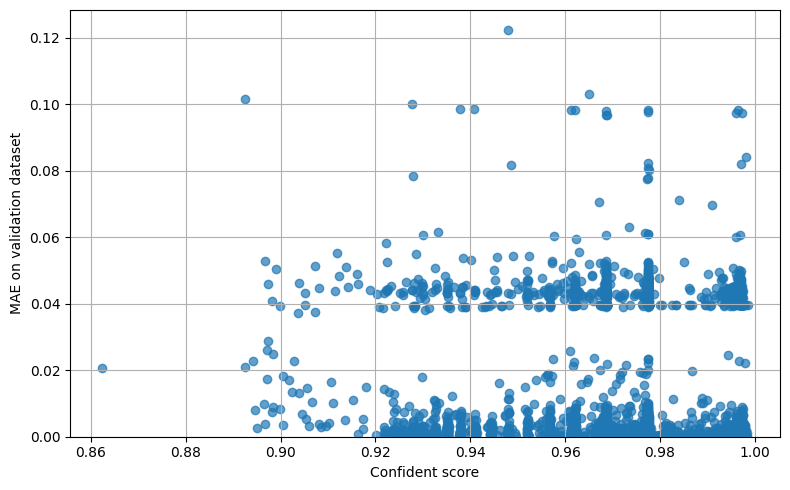

In [32]:
mae_list_test = calculate_mae_list(y_pred_test, y_test)
plot_mae_vs_confidence(mae_list_test, confidence_rate_vector, title = None)